In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import train_test_split,GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier,GradientBoostingClassifier,RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import classification_report,accuracy_score


In [2]:
aplication=pd.read_csv('/kaggle/input/a-credit-card-dataset-for-machine-exam/application_record.csv')
credit=pd.read_csv('/kaggle/input/a-credit-card-dataset-for-machine-exam/credit_record.csv')

In [3]:
aplication.info()
print("######################")
credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     438557 non-null  object 
 7   NAME_EDUCATION_TYPE  438557 non-null  object 
 8   NAME_FAMILY_STATUS   438557 non-null  object 
 9   NAME_HOUSING_TYPE    438557 non-null  object 
 10  DAYS_BIRTH           438557 non-null  int64  
 11  DAYS_EMPLOYED        438557 non-null  int64  
 12  FLAG_MOBIL           438557 non-null  int64  
 13  FLAG_WORK_PHONE      438557 non-null  int64  
 14  FLAG_PHONE           438557 non-null  int64  
 15  FLAG_EMAIL       

In [4]:
#check null values
aplication.isnull().sum()

ID                          0
CODE_GENDER                 0
FLAG_OWN_CAR                0
FLAG_OWN_REALTY             0
CNT_CHILDREN                0
AMT_INCOME_TOTAL            0
NAME_INCOME_TYPE            0
NAME_EDUCATION_TYPE         0
NAME_FAMILY_STATUS          0
NAME_HOUSING_TYPE           0
DAYS_BIRTH                  0
DAYS_EMPLOYED               0
FLAG_MOBIL                  0
FLAG_WORK_PHONE             0
FLAG_PHONE                  0
FLAG_EMAIL                  0
OCCUPATION_TYPE        134203
CNT_FAM_MEMBERS             0
dtype: int64

In [5]:
credit.isnull().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [6]:
# replace null value with mode
mode_value=aplication['OCCUPATION_TYPE'].mode()[0]
mode_value

'Laborers'

In [7]:
aplication['OCCUPATION_TYPE']=aplication['OCCUPATION_TYPE'].fillna(mode_value)
aplication.isnull().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
DAYS_BIRTH             0
DAYS_EMPLOYED          0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
dtype: int64

In [8]:
# check duplicate
print("duplicate in aplication",aplication.duplicated().sum())
print("duplicate in credit",credit.duplicated().sum())

duplicate in aplication 0
duplicate in credit 0


In [9]:
# transform DAYS_BIRTH into AGE
aplication['AGE']=(- aplication['DAYS_BIRTH'])//365

# Transform DAYS_EMPLOYED into years and handle anomalies
aplication['YEARS_EMPLOYED'] = aplication['DAYS_EMPLOYED'].apply(lambda x: -x // 365 if x < 0 else 0)

In [10]:
aplication.drop(['DAYS_BIRTH','DAYS_EMPLOYED'],axis=1,inplace=True)

In [11]:
# merge data
merged_data=aplication.merge(credit,on='ID',how='inner')
merged_data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED,MONTHS_BALANCE,STATUS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,32,12,0,C
1,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,32,12,-1,C
2,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,32,12,-2,C
3,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,32,12,-3,C
4,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,1,1,0,0,Laborers,2.0,32,12,-4,C


In [12]:
merged_data.isnull().sum()

ID                     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
NAME_INCOME_TYPE       0
NAME_EDUCATION_TYPE    0
NAME_FAMILY_STATUS     0
NAME_HOUSING_TYPE      0
FLAG_MOBIL             0
FLAG_WORK_PHONE        0
FLAG_PHONE             0
FLAG_EMAIL             0
OCCUPATION_TYPE        0
CNT_FAM_MEMBERS        0
AGE                    0
YEARS_EMPLOYED         0
MONTHS_BALANCE         0
STATUS                 0
dtype: int64

<Axes: >

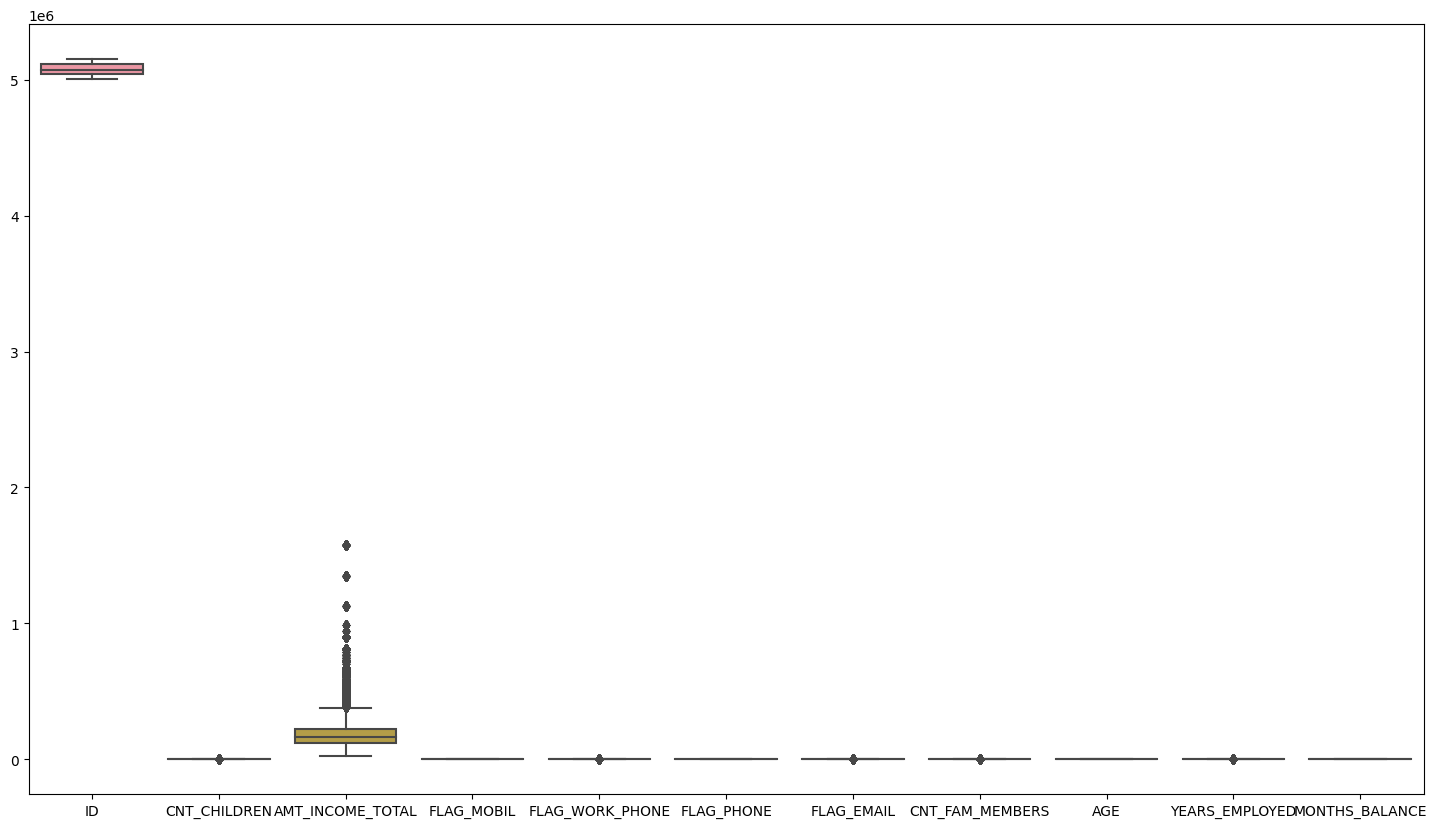

In [13]:
fig=plt.figure(figsize=(18,10))
sns.boxplot(data=merged_data)

In [14]:
#remove outlier
q1=merged_data['AMT_INCOME_TOTAL'].quantile(0.25)
q3=merged_data['AMT_INCOME_TOTAL'].quantile(0.75)
IQR=q3-q1
lower_fence=q1-1.5*IQR
upper_fence=q3+1.5*IQR
merged_data=merged_data[(merged_data['AMT_INCOME_TOTAL']>=lower_fence)&(merged_data['AMT_INCOME_TOTAL']<=upper_fence)]

<Axes: >

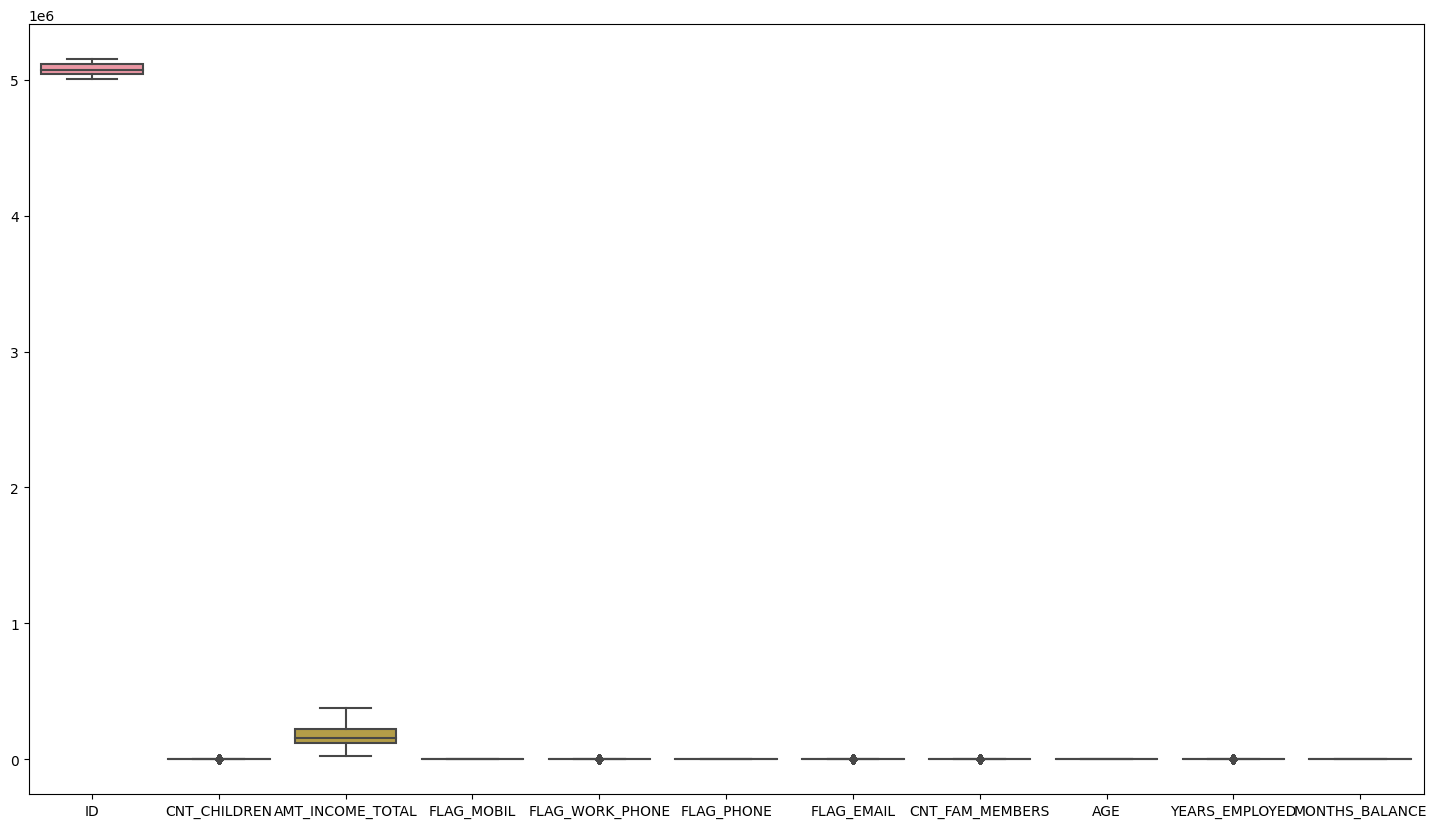

In [15]:
fig=plt.figure(figsize=(18,10))
sns.boxplot(merged_data)

In [16]:
merged_data.describe()

,ID,CNT_CHILDREN,AMT_INCOME_TOTAL,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED,MONTHS_BALANCE
count,7.437280e+05,743728.000000,743728.000000,743728.0,743728.000000,743728.000000,743728.000000,743728.000000,743728.000000,743728.000000,743728.000000
mean,5.078700e+06,0.424866,174384.747915,1.0,0.231001,0.297388,0.089094,2.204208,43.685467,5.907489,-19.387622
std,4.176313e+04,0.744836,71871.844084,0.0,0.421473,0.457109,0.284880,0.906471,11.329148,6.650967,14.088956
min,5.008806e+06,0.000000,27000.000000,1.0,0.000000,0.000000,0.000000,1.000000,20.000000,0.000000,-60.000000
25%,5.044533e+06,0.000000,121500.000000,1.0,0.000000,0.000000,0.000000,2.000000,34.000000,1.000000,-29.000000
50%,5.069492e+06,0.000000,157500.000000,1.0,0.000000,0.000000,0.000000,2.000000,43.000000,4.000000,-17.000000
75%,5.115555e+06,1.000000,225000.000000,1.0,0.000000,1.000000,0.000000,3.000000,53.000000,8.000000,-8.000000
max,5.150487e+06,19.000000,378000.000000,1.0,1.000000,1.000000,1.000000,20.000000,68.000000,43.000000,0.000000


In [17]:
# Handle categorical data encoding
le=LabelEncoder()
categorical_col=['CODE_GENDER','FLAG_OWN_CAR','FLAG_OWN_REALTY','NAME_INCOME_TYPE','NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS'
                 ,'NAME_HOUSING_TYPE','OCCUPATION_TYPE']
for col in categorical_col:
    merged_data[col]=le.fit_transform(merged_data[col])
    

In [18]:
x=merged_data.drop('STATUS',axis=1)
y=merged_data['STATUS']

In [19]:
# Scale the data using MinMaxScaler
mm=MinMaxScaler()
x_scaled=mm.fit_transform(x)
x=pd.DataFrame(x_scaled,columns=x.columns)
x.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,AGE,YEARS_EMPLOYED,MONTHS_BALANCE
0,0.0,1.0,1.0,1.0,0.0,0.24359,1.0,1.0,0.25,0.2,0.0,0.0,0.0,0.0,0.941176,0.052632,0.791667,0.069767,1.000000
1,0.0,1.0,1.0,1.0,0.0,0.24359,1.0,1.0,0.25,0.2,0.0,0.0,0.0,0.0,0.941176,0.052632,0.791667,0.069767,0.983333
2,0.0,1.0,1.0,1.0,0.0,0.24359,1.0,1.0,0.25,0.2,0.0,0.0,0.0,0.0,0.941176,0.052632,0.791667,0.069767,0.966667
3,0.0,1.0,1.0,1.0,0.0,0.24359,1.0,1.0,0.25,0.2,0.0,0.0,0.0,0.0,0.941176,0.052632,0.791667,0.069767,0.950000
4,0.0,1.0,1.0,1.0,0.0,0.24359,1.0,1.0,0.25,0.2,0.0,0.0,0.0,0.0,0.941176,0.052632,0.791667,0.069767,0.933333


In [20]:
# split data
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [22]:
lr=LogisticRegression(max_iter=500,solver='saga')
rf=RandomForestClassifier()
gb=GradientBoostingClassifier()
ada=AdaBoostClassifier()
dt=DecisionTreeClassifier()
models=[lr,rf,gb,ada,dt]
model_names=['LogisticRegression','RandomForestClassifier','GradientBoostingClassifier','AdaBoostClassifier','DecisionTreeClassifier']



for i in range(len(models)):
  models[i].fit(x_train,y_train)
  y_pred=models[i].predict(x_test)
  print(model_names[i])
  print('accuracy_score: ',accuracy_score(y_test,y_pred))

LogisticRegression
accuracy_score:  0.471098382477512
RandomForestClassifier
accuracy_score:  0.8845952160058086
GradientBoostingClassifier
accuracy_score:  0.4955763516329851
AdaBoostClassifier
accuracy_score:  0.47353206136635606
DecisionTreeClassifier
accuracy_score:  0.8702553345972329


In [ ]:
param={'n_estimators':[50,100,200]}
grid=GridSearchCV(estimator=rf,param_grid=param,cv=5)
grid.fit(x_train,y_train)
best_params=grid.best_params_
best_score=grid.best_score_
best_estimator=grid.best_estimator_
print('best_params: ',best_params)
print('best_score: ',best_score)
print('best_estimator: ',best_estimator)
best_estimator.fit(x_train,y_train)
y_pred=best_estimator.predict(x_test)
print('accuracy_score: ',accuracy_score(y_test,y_pred))